In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


In [26]:
content_path = './img/inputs/in4.png'
style_path = './img/styles/st4.png'
#C:\Users\Avanth\OneDrive\Desktop\neural project\img\inputs\in10 .png

In [27]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [28]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

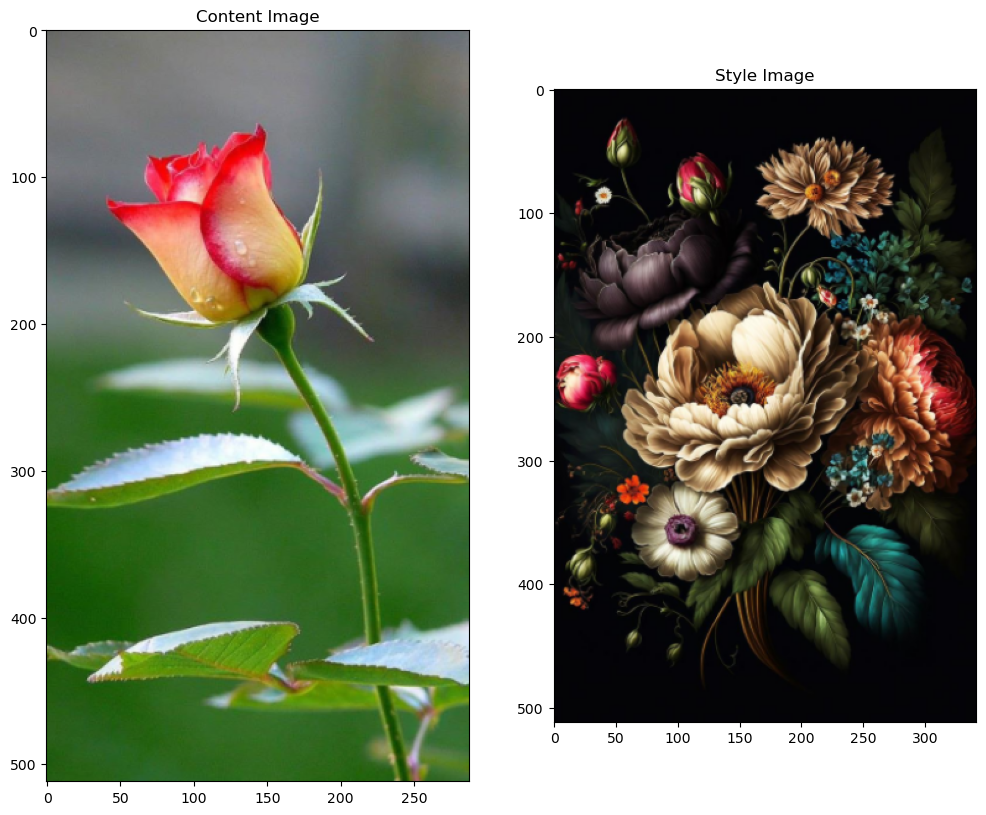

In [29]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [30]:
# Preprocess content and style images
content_image_preprocessed = tf.keras.applications.resnet.preprocess_input(content_image)
style_image_preprocessed = tf.keras.applications.resnet.preprocess_input(style_image)


In [31]:
x = tf.keras.applications.resnet.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
resnet = tf.keras.applications.ResNet50(include_top=True, weights='imagenet')
prediction_probabilities = resnet(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [32]:
predicted_top_5 = tf.keras.applications.resnet.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


[('hip', 0.46486247),
 ('hummingbird', 0.0806692),
 ('goldfinch', 0.04900301),
 ('sulphur_butterfly', 0.036819495),
 ('pomegranate', 0.03659308)]

In [33]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

print()
for layer in resnet.layers:
    print(layer.name)


input_6
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3

In [34]:
content_layers = ['conv5_block3_out'] 

style_layers = ['conv1_relu',
                'conv2_block3_out',
                'conv3_block4_out', 
                'conv4_block6_out', 
                'conv5_block3_out']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [35]:
def resnet_layers(layer_names):
    """ Creates a ResNet model that returns a list of intermediate output values."""
    # Load our model. Load pretrained ResNet, trained on ImageNet data
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
    resnet.trainable = False
  
    outputs = [resnet.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([resnet.input], outputs)
    return model


In [36]:
style_extractor = resnet_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

conv1_relu
  shape:  (1, 256, 171, 64)
  min:  0.0
  max:  16.441923
  mean:  1.4902123

conv2_block3_out
  shape:  (1, 128, 86, 256)
  min:  0.0
  max:  14.320694
  mean:  0.98264295

conv3_block4_out
  shape:  (1, 64, 43, 512)
  min:  0.0
  max:  17.933191
  mean:  0.8210648

conv4_block6_out
  shape:  (1, 32, 22, 1024)
  min:  0.0
  max:  28.689287
  mean:  0.5435344

conv5_block3_out
  shape:  (1, 16, 11, 2048)
  min:  0.0
  max:  56.895195
  mean:  0.3596272



In [37]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [38]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.resnet = resnet_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.resnet.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.resnet.preprocess_input(inputs)
        outputs = self.resnet(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [39]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   conv1_relu
    shape:  (1, 64, 64)
    min:  0.0
    max:  50.39662
    mean:  2.1839962

   conv2_block3_out
    shape:  (1, 256, 256)
    min:  0.00023267185
    max:  14.990884
    mean:  0.92023563

   conv3_block4_out
    shape:  (1, 512, 512)
    min:  0.0073472834
    max:  8.998203
    mean:  0.5862011

   conv4_block6_out
    shape:  (1, 1024, 1024)
    min:  0.0
    max:  9.30688
    mean:  0.28796113

   conv5_block3_out
    shape:  (1, 2048, 2048)
    min:  0.0
    max:  78.14609
    mean:  0.126351

Contents:
   conv5_block3_out
    shape:  (1, 16, 9, 2048)
    min:  0.0
    max:  35.330585
    mean:  0.25263909


In [40]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)


In [41]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [42]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [43]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


In [44]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

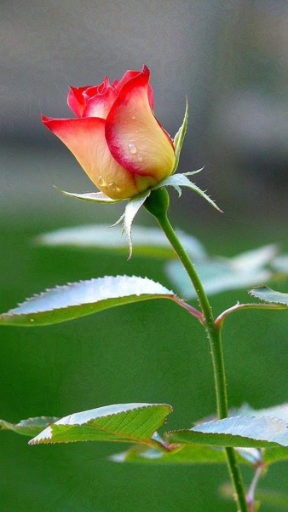

In [45]:
train_step(image)
train_step(image)
train_step(image)

tensor_to_image(image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    # Calculate SSIM and PSNR
    ssim_val = tf.image.ssim(content_image, image, max_val=1.0)
    psnr_val = tf.image.psnr(content_image, image, max_val=1.0)
    print("SSIM:", ssim_val.numpy())
    print("PSNR:", psnr_val.numpy())

end = time.time()
  


....................................................................................

In [ ]:
import datetime
# Convert the generated image tensor to a PIL Image
generated_image_pil = tensor_to_image(image)

# Generate a timestamp for the output filename
timestamp = time.strftime("%Y%m%d%H%M%S")

# Define the output folder and filename
output_folder = './img/final_resnet/'
output_filename = f'generated_image_{timestamp}.png'
output_path = os.path.join(output_folder, output_filename)

# Save the generated image
generated_image_pil.save(output_path)

print(f"Generated image saved at: {output_path}")